# Arbaro demo scene

Notebook: Hannah Weiser, 2025

This demo showcases two highly detailed tree models scanned from two terrestrial laser scanning (TLS) scanning positions.

In [1]:
import helios
from helios.settings import OutputFormat, LogVerbosity # these should not have to be imported extra?
import numpy as np

## Creating the virtual scene

In [2]:
# load objs and create transformations
groundplane = helios.ScenePart.from_obj("../data/sceneparts/basic/groundplane/groundplane.obj").scale(100)  # scale groundplane by 100
tree1 = helios.ScenePart.from_obj("../data/sceneparts/arbaro/black_tupelo_low.obj", up_axis="y")  # 3D models exported from Blender often have the Y-axis as "up-axis"
tree2 = helios.ScenePart.from_obj("../data/sceneparts/arbaro/sassafras_low.obj", up_axis="y")
# Trees should both be scaled down by half and translated
tree1 = tree1.scale(0.5).translate([0.0, 15.0, 0.0])
tree2 = tree2.scale(0.5).translate([-10.0, 15.0, 0.0])
#create scene
scene = helios.StaticScene(scene_parts=[groundplane, tree1, tree2])

## Platform and Scanner

In [3]:
from helios.scanner import riegl_vz_400
from helios.platforms import tripod

scanner = riegl_vz_400()
platform = tripod()

## Scanner Settings

In [4]:
# these scanner settings will be shared between all legs
scanner_settings = helios.ScannerSettings(pulse_frequency=100_000,  # Hz
                                          scan_frequency=120,  # Hz
                                          min_vertical_angle=-40,  # °
                                          max_vertical_angle=60,
                                          head_rotation=10  # °/s
                                         )
# for rotating head and rotating mirror terrestrial laser scanners, we can also provide 
# the vertical and horizontal angular resolution instead of scan frequency and head rotation speed
scanner_settings2 = helios.ScannerSettings(pulse_frequency=100_000,  # Hz
                                           vertical_resolution=0.2,  # °
                                           horizontal_resolution=0.2,
                                           min_vertical_angle=-40,  # °
                                           max_vertical_angle=60
                                          )

## Scan Positions

In [5]:
survey = helios.Survey(scanner=scanner, platform=platform, scene=scene)
# first scan position
survey.add_leg(scanner_settings=scanner_settings,
               x=1.0,
               y=25.5,
               z=1.5,
               force_on_ground=True,  # this works because of the specification in the groundplane.mtl file
               rotation_start_angle=100,  # °
               rotation_stop_angle=225
              )
# second scan position, here we use the other scan setting definition
survey.add_leg(scanner_settings=scanner_settings,  # this is not working..
               x=-4.0,
               y=-2.5,
               z=1.5,
               force_on_ground=True,
               rotation_start_angle=-45,
               rotation_stop_angle=45
              )

## Executing the survey

In [6]:
points, trajectories = survey.run(verbosity=LogVerbosity.VERBOSE, format=OutputFormat.NPY)

`points` and `trajectories` are numpy arrays of structured data type:

In [8]:
points[:3]

array([(0, 0, [3.38123858e+01, 8.24988204e+01, 1.78507401e-03], [ 0.49831717,  0.86563322, -0.04857085], [ 1.       , 25.5      , -3.7726975], 65.84638766,   10637.27541418, 0., 1, 1, 129, 0, 243032.00823),
       (0, 0, [5.44078119e+00, 3.32031273e+01, 3.07091430e-03], [ 0.46998561,  0.81525273, -0.33834378], [ 1.       , 25.5      , -3.7726975],  9.44875987, 4089276.38629983, 0., 1, 1,  70, 0, 243032.00764),
       (0, 0, [5.51259508e+00, 3.33278875e+01, 2.50925335e-03], [ 0.47082052,  0.81672075, -0.33360943], [ 1.       , 25.5      , -3.7726975],  9.58453359, 3767136.83564574, 0., 1, 1,  71, 0, 243032.00765)],
      dtype=[('channel_id', '<u8'), ('hit_object_id', '<i4'), ('position', '<f8', (3,)), ('beam_direction', '<f8', (3,)), ('beam_origin', '<f8', (3,)), ('distance', '<f8'), ('intensity', '<f8'), ('echo_width', '<f8'), ('return_number', '<i4'), ('number_of_returns', '<i4'), ('fullwave_index', '<i4'), ('classification', '<i4'), ('gps_time', '<f8')])

In [9]:
trajectories[:3]

array([(243032.  , [ 1. , 25.5,  1.5], -0., 0., -0.),
       (243032.01, [ 1. , 25.5,  1.5], -0., 0., -0.),
       (243032.02, [ 1. , 25.5,  1.5], -0., 0., -0.)],
      dtype=[('gps_time', '<f8'), ('position', '<f8', (3,)), ('roll', '<f8'), ('pitch', '<f8'), ('yaw', '<f8')])

There are also different output formats besides numpy arrays. If we rather want to write the point clouds to file, we could also specify `OutputFormat.LAZ` which will write compressed LAS (i.e., LAZ) files, the community standard file format for LiDAR point clouds. We can also set different log verbosity levels.

In [ ]:
# survey.run(verbosity=LogVerbosity.VERBOSE, format=OutputFormat.LAZ)

## Visualizing the result

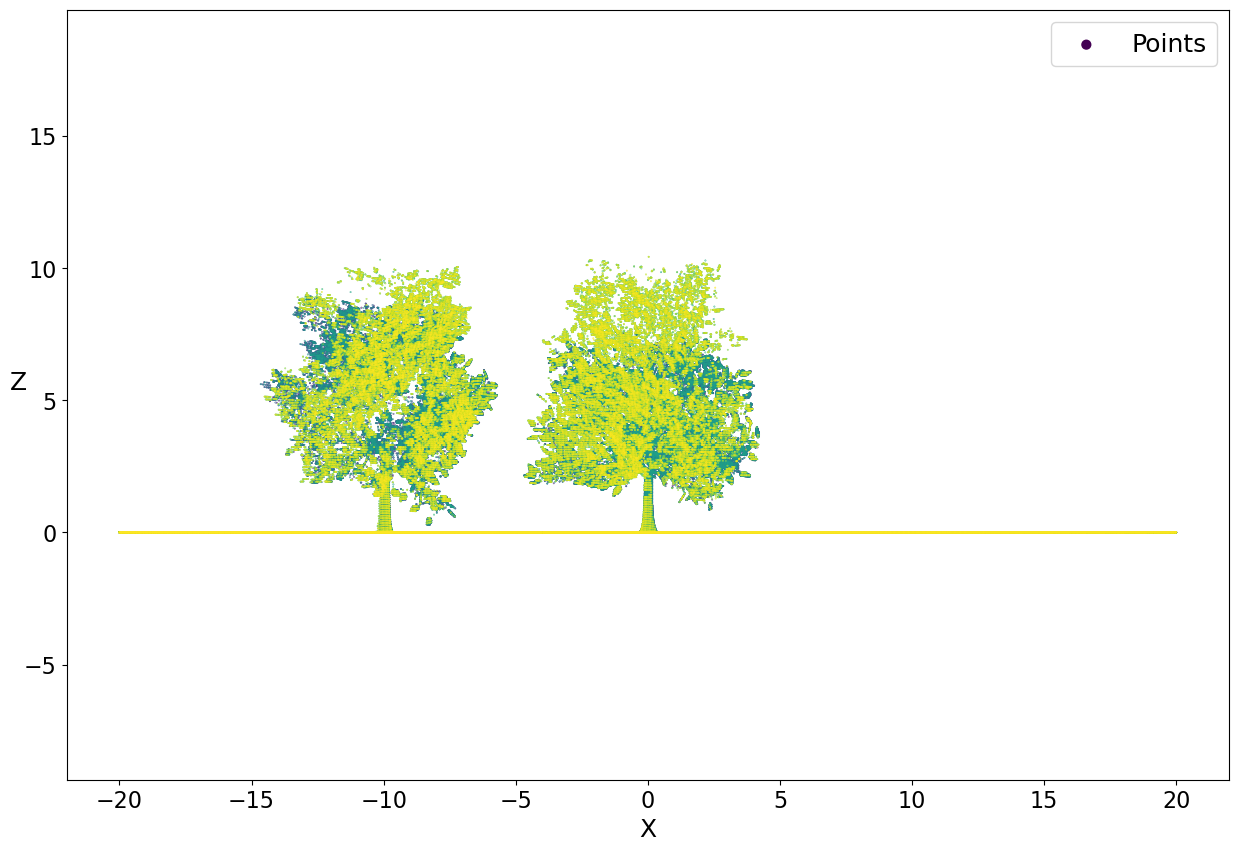

In [10]:
import matplotlib.pyplot as plt

pos = points["position"]

# discard points outside of [-20, -20] to [20, 20] (x, y)
points_sub = points[
    (pos[:, 0] > -20) & (pos[:, 1] > -20) & (pos[:, 0] < 20) & (pos[:, 1] < 20)
]
pos = points_sub["position"]

fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(
   pos[:, 0], pos[:, 2], s=0.1, label="Points", c=points_sub["gps_time"]
)
plt.axis("equal")
ax.tick_params(labelsize=16)
plt.xlabel("X", fontsize=18)
plt.ylabel("Z", fontsize=18, rotation=0)
plt.legend(fontsize=18, markerscale=20)
plt.show()